## SCpliceVAE Interactive Test Notebook

#### 1. Setup and Imports

In [30]:
# ==============================================================================
# 1. CLASS DEFINITIONS HERE AND IMPORTS
# ==============================================================================

import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scipy.sparse as sp
from scipy.sparse import csr_matrix, issparse
from collections import defaultdict
import json 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import anndata as ad
import os
import matplotlib.pyplot as plt  # For plotting results
from typing import Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import anndata as ad
import os
import matplotlib.pyplot as plt
import seaborn as sns # For better plotting aesthetics
from umap import UMAP # Import UMAP
from typing import Dict, List, Optional, Tuple

# Ensure the path to your module is in sys.path
# Modify this to point to where your modules are located
module_path = '/gpfs/commons/home/kisaev/multivi_tools_splicing/src/SCplice_vae'  # Change this to your module path
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloaders import * 

from partial_vae import (
    PartialEncoder, 
    LinearDecoder, 
    PartialVAE, 
    binomial_loss_function, 
    beta_binomial_loss_function,
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#### 2. Load Some Simulated Data for Testing

In [31]:
# Load AnnData object with simulated single cell splicing data 
# Create synthetic data
adata = ad.read_h5ad('/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/SIMULATED/simulated_data_2025-03-12.h5ad')

# Basic info about the data
print("\nAnnData Summary:")
print(adata)
print("\nLayers:")
for layer_name, layer in adata.layers.items():
    print(f"  {layer_name}: {type(layer)}, shape {layer.shape}")


AnnData Summary:
AnnData object with n_obs × n_vars = 19942 × 9798
    obs: 'cell_id', 'age', 'batch', 'cell_ontology_class', 'method', 'mouse.id', 'sex', 'tissue', 'old_cell_id_index', 'cell_clean', 'cell_id_index', 'subtissue_clean', 'cell_type_grouped', 'cell_type'
    var: 'junction_id', 'event_id', 'splice_motif', 'label_5_prime', 'label_3_prime', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'non_zero_count_cells', 'non_zero_cell_prop', 'annotation_status_score', 'non_zero_cell_prop_score', 'splice_motif_score', 'junction_id_index', 'chr', 'start', 'end', 'index', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'sample_label', 'difference', 'true_label'
    uns: 'age_colors', 'cell_type_colors', 'neighbors', 'pca_explained_variance_ratio', 'tissue_colors', 'umap'
    obsm: 'X_leafletFA', 'X_pca', 'X_umap', 'phi_init_100_waypoints', 'phi_init_30_waypoints'
    varm: 'psi_init_100_waypoints', 'psi_init_30_w

/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
# Only keep the layers you're interested in
trimmed_layers = {
    key: adata.layers[key]
    for key in ["junc_ratio", "cell_by_cluster_matrix", "cell_by_junction_matrix"]
}

# Create trimmed AnnData
adata_trimmed = ad.AnnData(
    X=None,  # Don't include full X matrix
    obs=adata.obs.copy(),
    var=adata.var.copy(),
    layers=trimmed_layers
)

In [33]:
# --- Configuration ---
X_LAYER_NAME = 'junc_ratio'
JUNCTION_COUNTS_LAYER_NAME = 'cell_by_junction_matrix'
CLUSTER_COUNTS_LAYER_NAME = 'cell_by_cluster_matrix'
BATCH_SIZE = 128 # Adjust as needed
NUM_WORKERS = 2 # Adjust based on your system

# --- Create Train/Validation Split ---
all_indices = np.arange(adata_trimmed.n_obs)
train_indices, val_indices = train_test_split(all_indices, test_size=0.3, random_state=42) # 30% validation

# --- Create Datasets ---
train_dataset = AnnDataDataset(
    adata_trimmed,
    x_layer=X_LAYER_NAME,
    junction_counts_layer=JUNCTION_COUNTS_LAYER_NAME,
    cluster_counts_layer=CLUSTER_COUNTS_LAYER_NAME,
    obs_indices=train_indices.tolist() # Pass the list of indices for the training set
)

val_dataset = AnnDataDataset(
    adata_trimmed,
    x_layer=X_LAYER_NAME,
    junction_counts_layer=JUNCTION_COUNTS_LAYER_NAME,
    cluster_counts_layer=CLUSTER_COUNTS_LAYER_NAME,
    obs_indices=val_indices.tolist() # Pass the list of indices for the validation set
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,         # Don't shuffle training data
    num_workers=NUM_WORKERS,
    pin_memory=True,      # Can speed up CPU->GPU transfer
    drop_last=False       # Keep the last batch even if smaller
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,        # No need to shuffle validation data
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

# --- Get dataset size and number of batches (for loss function scaling) ---
n_train_samples = len(train_dataset)
k_train_batches = len(train_loader)
n_val_samples = len(val_dataset)
k_val_batches = len(val_loader)

print(f"Training samples: {n_train_samples}, Batches: {k_train_batches}")
print(f"Validation samples: {n_val_samples}, Batches: {k_val_batches}")

Training samples: 13959, Batches: 110
Validation samples: 5983, Batches: 47


In [34]:
# ==============================================================================
# 2. CONFIGURATION & HYPERPARAMETERS
# ==============================================================================

# --- Data ---
X_LAYER_NAME = 'junc_ratio'
JUNCTION_COUNTS_LAYER_NAME = 'cell_by_junction_matrix'
CLUSTER_COUNTS_LAYER_NAME = 'cell_by_cluster_matrix'
INPUT_DIM = adata_trimmed.n_vars # Get input dimension from data
print(f"Input Dimension (n_vars): {INPUT_DIM}")

# --- Model Architecture ---
# INPUT_DIM will be set from data
CODE_DIM = 128             # Dimension K for feature embeddings (junction embeddings)
H_HIDDEN_DIM = 64         # Hidden dim for encoder's h_layer 
ENCODER_HIDDEN_DIM = 32  # Hidden dim for encoder's final MLP
LATENT_DIM = 10           # Dimension Z for latent space
DROPOUT_RATE = 0.01

# --- Training ---
LOSS_TYPE = 'binomial' # Choose 'binomial' or 'beta_binomial'
LEARN_CONCENTRATION = False  # Set True for beta-binomial if you want learnable concentration
FIXED_CONCENTRATION = None  # Set to a float (e.g., 10.0) if using beta-binomial with FIXED concentration
                            # If set, overrides LEARN_CONCENTRATION=True

NUM_EPOCHS = 200          # Max number of epochs
LEARNING_RATE = 0.001
PATIENCE = 3             # Early stopping patience (epochs)
SCHEDULE_STEP_SIZE = 10    # LR scheduler step size
SCHEDULE_GAMMA = 0.2      # LR scheduler factor

# --- Output & Logging ---
OUTPUT_DIR = "./vae_training_output" # Directory to save results

Input Dimension (n_vars): 9798


In [35]:
# ==============================================================================
# 3. MODEL INITIALIZATION & LOSS FUNCTION SELECTION
# ==============================================================================

# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Instantiate Model ---
# Determine if concentration should be learned based on settings
should_learn_concentration = (LOSS_TYPE == 'beta_binomial') and (FIXED_CONCENTRATION is None) and LEARN_CONCENTRATION

model = PartialVAE(
    input_dim=INPUT_DIM,
    code_dim=CODE_DIM,
    h_hidden_dim=H_HIDDEN_DIM,
    encoder_hidden_dim=ENCODER_HIDDEN_DIM,
    latent_dim=LATENT_DIM,
    dropout_rate=DROPOUT_RATE,
    learn_concentration=should_learn_concentration # Pass the determined flag
)
model.to(device)
print("Model initialized:")
print(model)

# --- Choose Loss Function ---
if LOSS_TYPE == 'binomial':
    chosen_loss_function = binomial_loss_function
    print("Using Binomial Loss.")
    if FIXED_CONCENTRATION is not None or LEARN_CONCENTRATION:
         print("Warning: Concentration parameters ignored for binomial loss.")
elif LOSS_TYPE == 'beta_binomial':
    chosen_loss_function = beta_binomial_loss_function
    print("Using Beta-Binomial Loss.")
    if FIXED_CONCENTRATION is not None:
        print(f"Using FIXED concentration: {FIXED_CONCENTRATION}")
    elif should_learn_concentration:
        print("Using LEARNABLE concentration.")
    else:
        print("Warning: Beta-binomial selected but no concentration specified (fixed or learnable). Check config.")
else:
    raise ValueError(f"Unknown LOSS_TYPE: '{LOSS_TYPE}'. Choose 'binomial' or 'beta_binomial'.")


Using device: cuda
Model initialized:
PartialVAE(
  (encoder): PartialEncoder(
    (h_layer): Sequential(
      (0): Linear(in_features=129, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.01, inplace=False)
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
    )
    (encoder_mlp): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.01, inplace=False)
      (4): Linear(in_features=32, out_features=20, bias=True)
    )
  )
  (decoder): LinearDecoder(
    (linear): Linear(in_features=10, out_features=9798, bias=True)
  )
)
Using Binomial Loss.


In [36]:
# check the first element in the train dataloader 
for batch in train_loader:
    print("Batch keys:", batch.keys())
    print("Batch shape:", {k: v.shape for k, v in batch.items()})
    break

Batch keys: dict_keys(['x', 'mask', 'junction_counts', 'cluster_counts'])
Batch shape: {'x': torch.Size([128, 9798]), 'mask': torch.Size([128, 9798]), 'junction_counts': torch.Size([128, 9798]), 'cluster_counts': torch.Size([128, 9798])}


In [37]:
# ==============================================================================
# 4. TRAINING EXECUTION
# ==============================================================================

# Create output directory if it doesn't exist
if OUTPUT_DIR:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Output will be saved to: {os.path.abspath(OUTPUT_DIR)}")

# --- Start Training ---
try:
    train_losses, val_losses, epochs_trained = model.train_model(
        loss_function=chosen_loss_function,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        patience=PATIENCE,
        fixed_concentration=FIXED_CONCENTRATION, # Pass the fixed value if set
        schedule_step_size=SCHEDULE_STEP_SIZE,
        schedule_gamma=SCHEDULE_GAMMA,
        output_dir=OUTPUT_DIR,
        # --- Specify keys matching AnnDataDataset output ---
        input_key='x',
        mask_key='mask',
        junction_counts_key='junction_counts',
        cluster_counts_key='cluster_counts'
    )
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback
    exit()


Output will be saved to: /gpfs/commons/home/kisaev/multivi_tools_splicing/testing/vae_training_output
Beginning training on device: cuda:0
Start training!
Epoch 001/200 | Train Loss: 88.4738 | LR: 1.0e-03
          | Val Loss:   82.7420
          | Val loss improved (inf -> 82.7420)
Epoch 002/200 | Train Loss: 80.2193 | LR: 1.0e-03
          | Val Loss:   77.3437
          | Val loss improved (82.7420 -> 77.3437)
Epoch 003/200 | Train Loss: 76.4551 | LR: 1.0e-03
          | Val Loss:   74.3970
          | Val loss improved (77.3437 -> 74.3970)
Epoch 004/200 | Train Loss: 74.2034 | LR: 1.0e-03
          | Val Loss:   73.3426
          | Val loss improved (74.3970 -> 73.3426)
Epoch 005/200 | Train Loss: 72.8212 | LR: 1.0e-03
          | Val Loss:   71.7073
          | Val loss improved (73.3426 -> 71.7073)
Epoch 006/200 | Train Loss: 71.8048 | LR: 1.0e-03
          | Val Loss:   70.8391
          | Val loss improved (71.7073 -> 70.8391)
Epoch 007/200 | Train Loss: 71.0331 | LR: 1.0e-03
 


Training complete.
Loss plot saved to ./vae_training_output/training_loss_plot.png


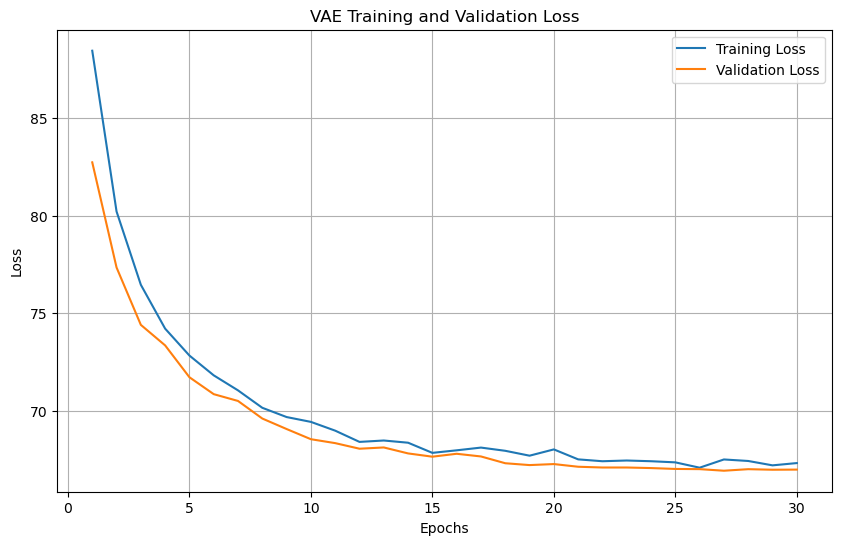

In [38]:
# ==============================================================================
# 5. POST-TRAINING (Example: Plot Losses)
# ==============================================================================
print("\nTraining complete.")

if train_losses and val_losses:
    plt.figure(figsize=(10, 6))
    epochs = range(1, epochs_trained + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('VAE Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    # Save the plot
    plot_path = "training_loss_plot.png"
    if OUTPUT_DIR:
        plot_path = os.path.join(OUTPUT_DIR, "training_loss_plot.png")
    plt.savefig(plot_path)
    print(f"Loss plot saved to {plot_path}")
    plt.show() # Uncomment to display plot interactively

In [39]:
# --- Select cells to embed ---
indices_to_use = np.arange(adata.n_obs)
print(f"Getting latent representations for {len(indices_to_use)} cells...")

CELL_TYPE_COLUMN = "cell_type"
cell_labels = adata.obs[CELL_TYPE_COLUMN][indices_to_use].astype(str).values

# --- Create Dataset and DataLoader for Inference ---
inference_dataset = AnnDataDataset(
    adata,
    x_layer=X_LAYER_NAME,
    junction_counts_layer=JUNCTION_COUNTS_LAYER_NAME,
    cluster_counts_layer=CLUSTER_COUNTS_LAYER_NAME,
    obs_indices=indices_to_use.tolist()
)

inference_loader = DataLoader(
    inference_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

# --- Encode latent representations (Z matrix) ---
latent_reps_list = []
model.eval()  # make sure in eval mode
with torch.no_grad():
    for i, batch in enumerate(inference_loader):
        x_batch = batch['x'].to(device)
        mask_batch = batch['mask'].to(device)
        latent_batch_np = model.get_latent_rep(x_batch, mask_batch)
        latent_reps_list.append(latent_batch_np)

all_latent_reps = np.concatenate(latent_reps_list, axis=0)
print(f"Finished collecting latent representations (shape={all_latent_reps.shape}).")

# --- Extract model weights ---
decoder_weight = model.decoder.linear.weight.detach().cpu().numpy()  # (n_junctions, latent_dim)
decoder_bias = model.decoder.linear.bias.detach().cpu().numpy()      # (n_junctions,)
feature_embeddings = model.get_features()                            # (n_junctions, code_dim)

# --- Save into AnnData object ---
adata.obsm["X_SCpliceVAE"] = all_latent_reps
adata.varm["decoder_weight"] = decoder_weight
adata.varm["feature_embeddings"] = feature_embeddings

print("Latent representations, decoder matrix, and feature embeddings saved to AnnData.")

Getting latent representations for 19942 cells...


/scratch/ipykernel_2887839/3358426504.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_labels = adata.obs[CELL_TYPE_COLUMN][indices_to_use].astype(str).values


Finished collecting latent representations (shape=(19942, 10)).
Latent representations, decoder matrix, and feature embeddings saved to AnnData.


In [40]:
feature_embeddings

array([[-0.02972212,  0.01312313, -0.02353696, ...,  0.00700556,
         0.0534265 , -0.02678475],
       [ 0.02804835, -0.00167545,  0.01892908, ...,  0.05604558,
        -0.00230501, -0.02128323],
       [ 0.01427879, -0.0039885 ,  0.01519567, ...,  0.03752762,
        -0.03259811, -0.02138127],
       ...,
       [ 0.02253717, -0.02190601,  0.02405383, ...,  0.02349898,
        -0.01262152, -0.04538912],
       [-0.03928539, -0.02934938, -0.01374583, ...,  0.02178676,
         0.07867437,  0.04009482],
       [-0.0422608 , -0.03830174,  0.0309861 , ...,  0.01585642,
         0.04216547, -0.04357706]], dtype=float32)

Running UMAP for dimensionality reduction...


/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Shape of 2D UMAP embedding: (19942, 2)
2D UMAP embedding saved into adata.obsm['X_umap_SCpliceVAE'].


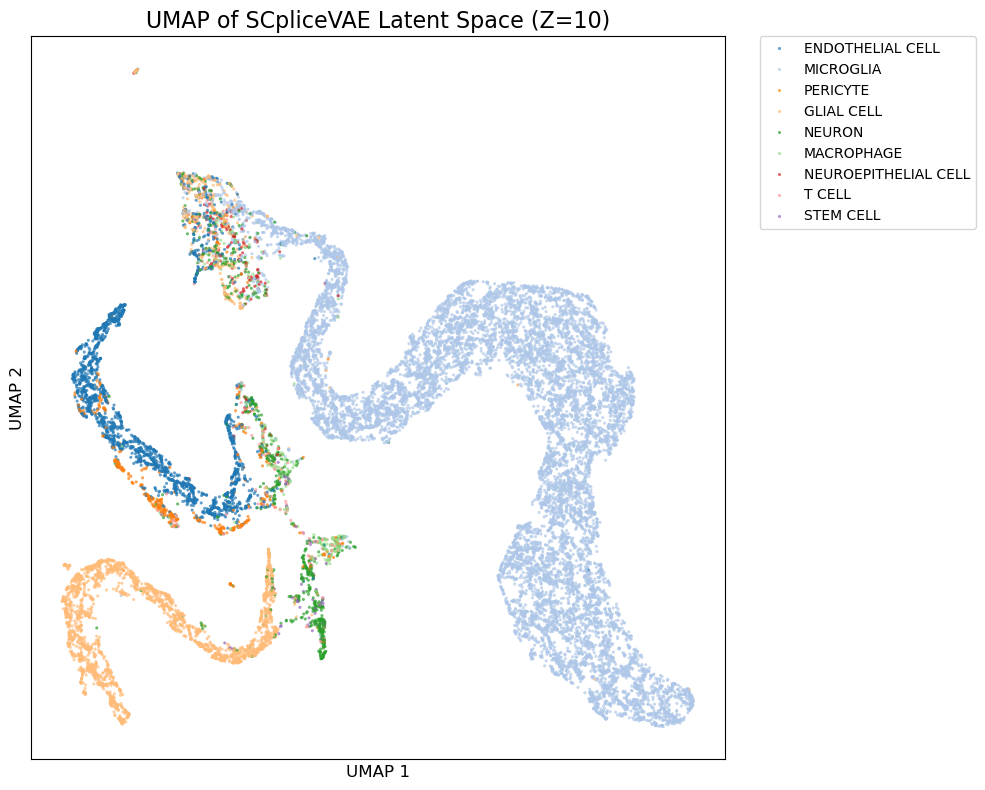

In [41]:
# ==============================================================================
# 5. DIMENSIONALITY REDUCTION (UMAP)
# ==============================================================================

# --- Visualization ---
# UMAP parameters (can be tuned)
N_NEIGHBORS = 8
MIN_DIST = 0.1
UMAP_METRIC = 'euclidean' # Distance metric in latent space

print("Running UMAP for dimensionality reduction...")
reducer = UMAP(
    n_components=2,       # Reduce to 2 dimensions for plotting
    n_neighbors=N_NEIGHBORS,    # Controls local vs global structure (adjust)
    min_dist=MIN_DIST,      # Controls tightness of clusters (adjust)
    metric=UMAP_METRIC,     # Distance metric in the latent space
    random_state=42       # For reproducibility
)

embedding_2d = reducer.fit_transform(all_latent_reps)
print(f"Shape of 2D UMAP embedding: {embedding_2d.shape}") # Should be (n_obs, 2)

# Save UMAP embedding into AnnData for easier reuse later
adata.obsm["X_umap_SCpliceVAE"] = embedding_2d

print("2D UMAP embedding saved into adata.obsm['X_umap_SCpliceVAE'].")

# --- Plot UMAP ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

num_unique_labels = len(np.unique(cell_labels))
palette = sns.color_palette('tab20', n_colors=num_unique_labels)

sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=cell_labels,
    palette=palette,
    s=5,
    alpha=0.7,
    linewidth=0
)

plt.title(f"UMAP of SCpliceVAE Latent Space (Z={LATENT_DIM})", fontsize=16)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  # move legend outside
plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import silhouette_score

# 1. Get latent embeddings (already saved)
X = adata.obsm["X_SCpliceVAE"]  # shape (n_cells, latent_dim)

# 2. Get cell_type labels
labels = adata.obs["cell_type"].astype(str).values

# 3. Calculate silhouette score
score = silhouette_score(X, labels, metric='euclidean')
print(f"Silhouette score based on SCpliceVAE latent space: {score:.4f}")

Silhouette score based on SCpliceVAE latent space: 0.2777


In [43]:
def plot_top_junctions_per_latent(adata, decoder_key="decoder_weight", top_k=10):
    decoder_weight = adata.varm[decoder_key]  # shape (n_junctions, latent_dim)
    junction_names = adata.var["junction_id"].values  # or "gene_name" if you prefer

    for latent_dim in range(decoder_weight.shape[1]):
        print(f"\nTop {top_k} junctions for latent dimension {latent_dim}:")
        
        # Get the weights for this latent dimension
        weights = decoder_weight[:, latent_dim]
        top_indices = np.argsort(np.abs(weights))[::-1][:top_k]
        
        for rank, idx in enumerate(top_indices):
            print(f"  {rank+1}. {junction_names[idx]} (weight={weights[idx]:.4f})")

plot_top_junctions_per_latent(adata, decoder_key="decoder_weight", top_k=10)


Top 10 junctions for latent dimension 0:
  1. chr1_128259537_128260833_+ (weight=-0.7070)
  2. chr5_125451772_125452147_+ (weight=-0.6955)
  3. chr1_171235087_171236356_- (weight=-0.6800)
  4. chr6_88505293_88506144_- (weight=-0.6698)
  5. chr7_111075712_111076279_- (weight=-0.6616)
  6. chr11_116107006_116107423_- (weight=-0.6594)
  7. chr3_33801390_33803074_+ (weight=-0.6580)
  8. chr9_13793232_13795236_+ (weight=-0.6566)
  9. chr1_65168604_65170958_- (weight=-0.6566)
  10. chr14_30912911_30913160_- (weight=-0.6522)

Top 10 junctions for latent dimension 1:
  1. chr8_63345886_63352180_+ (weight=0.5781)
  2. chr14_55769497_55770024_- (weight=-0.5417)
  3. chr4_154323480_154328663_- (weight=-0.5276)
  4. chr7_105565951_105566050_- (weight=-0.5251)
  5. chr7_44973880_44974594_- (weight=0.4903)
  6. chr3_88365802_88365881_+ (weight=-0.4708)
  7. chr6_112315911_112328662_+ (weight=-0.4706)
  8. chr5_136965169_136965916_+ (weight=0.4631)
  9. chr11_94060299_94067892_+ (weight=-0.4612)
  1